# Estratificação de dados *multi-label* com a biblioteca Scikit-multilearn

## Imports iniciais

In [1]:
!pip install scikit-multilearn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Leitura e exploração dos dados

In [3]:
df = pd.read_csv('Dataset/train.csv')

print('Número de instâncias: {}\nNúmero de atributos: {}\n'.format(len(df), len(df.columns)))

df[0:7]

Número de instâncias: 159571
Número de atributos: 8



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


### Análise das *labels*

In [0]:
def bar_values(ax, labels):
  
  rects = ax.patches

  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

  return ax

In [0]:
def plot_histogram_labels(title, x_label, y_label, labels, hue_label=None, data=None):

  sns.set(style='whitegrid', font_scale=2)
  plt.figure(figsize=(14, 8))

  ax = sns.barplot(x_label, y_label, hue=hue_label, data=data, palette='coolwarm')

  plt.title(title, fontsize=20)
  plt.xlabel('')
  plt.ylabel('Comentários', fontsize=15)

  bar_values(ax, labels)

  plt.show()

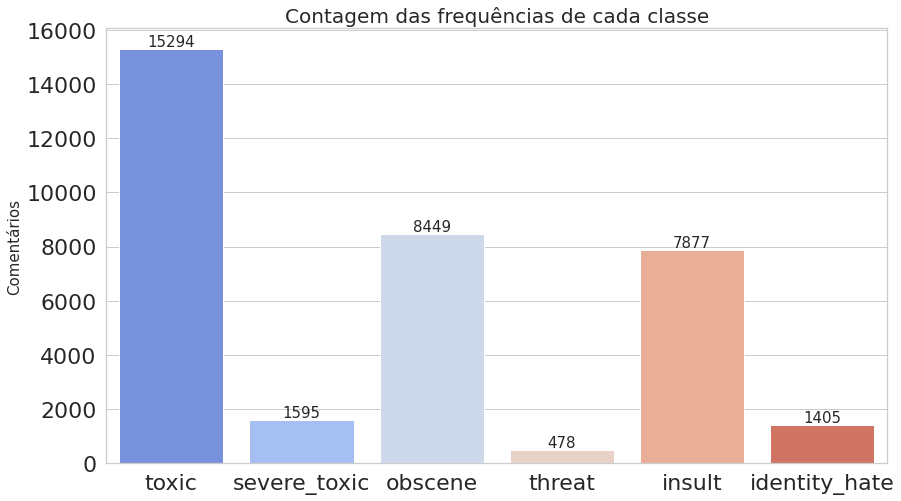

In [6]:
labels = list(df.iloc[:, 2:].columns.values)
labels_count = df[labels].sum().values

plot_histogram_labels(title='Contagem das frequências de cada classe', x_label=labels, y_label=labels_count,
                      labels=labels_count)

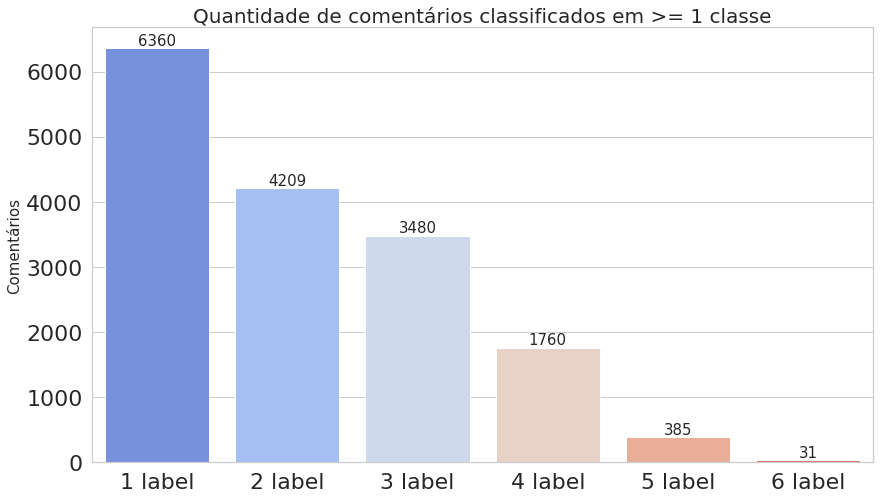

In [7]:
comments_count = df[labels].sum(axis=1)
multilabel_counts = (comments_count.value_counts()).iloc[1:]

indexes = [str(i) + ' label' for i in multilabel_counts.index.sort_values()]

plot_histogram_labels(title='Quantidade de comentários classificados em >= 1 classe', x_label=indexes, 
                      y_label=multilabel_counts.values, labels=multilabel_counts)

### *WordCloud* das palavras mais usadas

In [0]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud_text(text):

  cmap = plt.cm.coolwarm

  cloud = WordCloud(
      stopwords=STOPWORDS,
      background_color='white',
      colormap=cmap,
      collocations=False,
      width=2500,
      height=1800).generate(" ".join(text))

  return cloud

In [0]:
def plot_cloud_text(cloud, sub, nrows=False, ncols=False, index=False):

  if(nrows):
    plt.subplot(nrows, ncols, index)
    plt.axis('off')
    plt.title(sub, fontsize=20)
    plt.imshow(cloud);
  else:
    plt.axis('off')
    plt.title(sub, fontsize=20)
    plt.imshow(cloud);

In [0]:
comments = df['comment_text'].values

DICT_LABELS = {
    'toxic':         0,
    'severe_toxic':  0,
    'obscene':       0,
    'threat':        0,
    'insult':        0,
    'identity_hate': 0,
}

for l in DICT_LABELS:
    DICT_LABELS[l] = df[df[l] == 0]['comment_text'].values

cloud_comments = word_cloud_text(comments)
cloud_toxic = word_cloud_text(DICT_LABELS['toxic'])
cloud_severe_toxic = word_cloud_text(DICT_LABELS['severe_toxic'])
cloud_obscene = word_cloud_text(DICT_LABELS['obscene'])
cloud_threat = word_cloud_text(DICT_LABELS['threat'])
cloud_insult = word_cloud_text(DICT_LABELS['insult'])
cloud_id_hate = word_cloud_text(DICT_LABELS['identity_hate'])

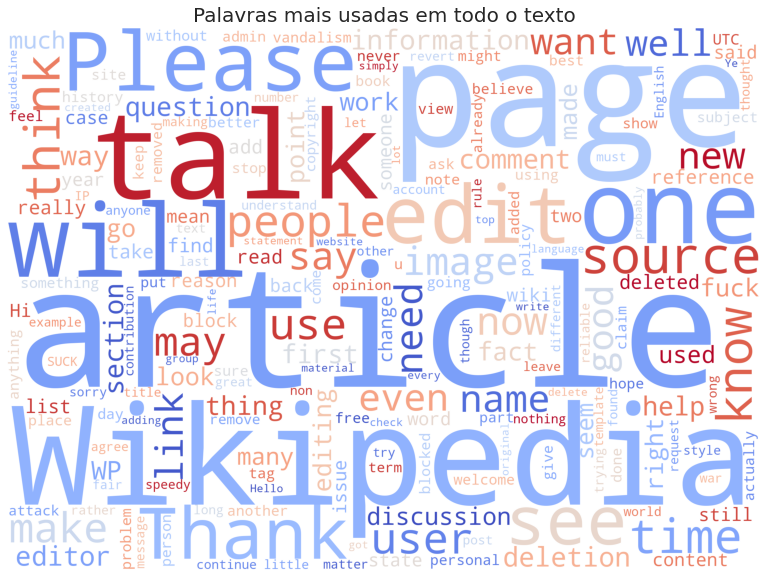

In [11]:
plt.figure(figsize=(20, 10))
plot_cloud_text(cloud_comments, 'Palavras mais usadas em todo o texto')

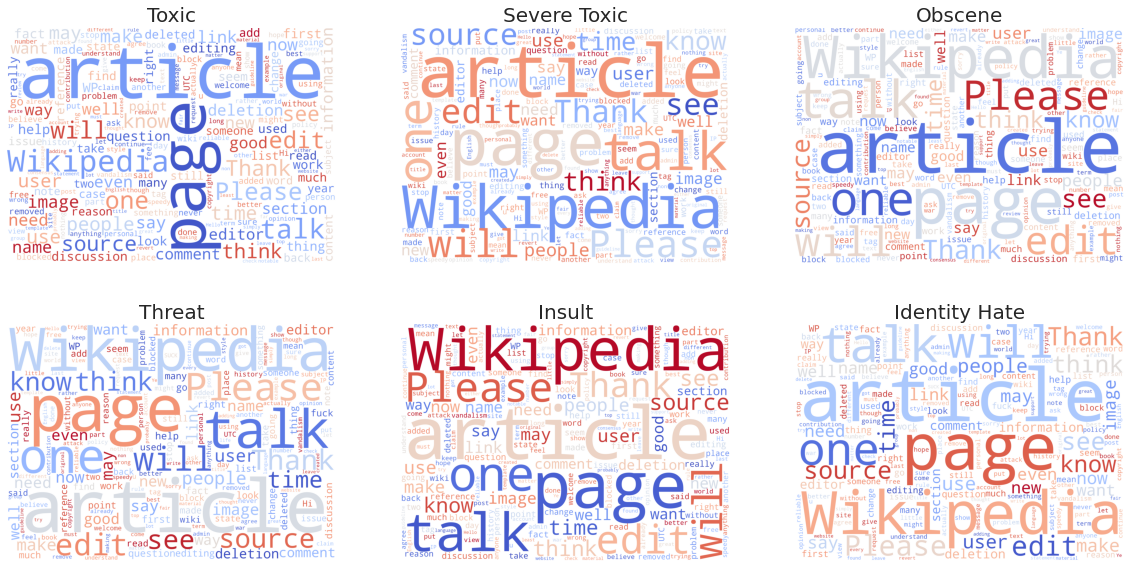

In [12]:
plt.figure(figsize=(20, 10))

plot_cloud_text(cloud_toxic, 'Toxic', nrows=2, ncols=3, index=1)
plot_cloud_text(cloud_severe_toxic, 'Severe Toxic', nrows=2, ncols=3, index=2)
plot_cloud_text(cloud_obscene, 'Obscene', nrows=2, ncols=3, index=3)
plot_cloud_text(cloud_threat, 'Threat', nrows=2, ncols=3, index=4)
plot_cloud_text(cloud_insult, 'Insult', nrows=2, ncols=3, index=5)
plot_cloud_text(cloud_id_hate, 'Identity Hate', nrows=2, ncols=3, index=6)

plt.show()

### Valores faltantes

In [13]:
print('Quantidade de valores faltantes: {}\n'.format(df.isna().sum()))

Quantidade de valores faltantes: id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64



### Comentários vazios

In [14]:
print('Quantidade de comentários vazios: {}'.format(len(df[df['comment_text'].isnull()])))

Quantidade de comentários vazios: 0


### Comentários sem classificação

In [15]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Percebe-se que os valores médios (*mean*) são muito pequenos (um pouco abaixo de 0.05). Aparentemente, muitos comentários não estão rotulados em nenhuma das seis categorias.

In [16]:
comments_unlabelled = df[(df['toxic'] != 1) & (df['severe_toxic'] != 1) & 
                         (df['obscene'] != 1) & (df['threat'] != 1) & 
                         (df['insult'] != 1) & (df['identity_hate'] != 1)]

print('Percentual de comentários sem classificação: {}%'.format(len(comments_unlabelled) / len(df)*100))

Percentual de comentários sem classificação: 89.83211235124176%


### Correlação

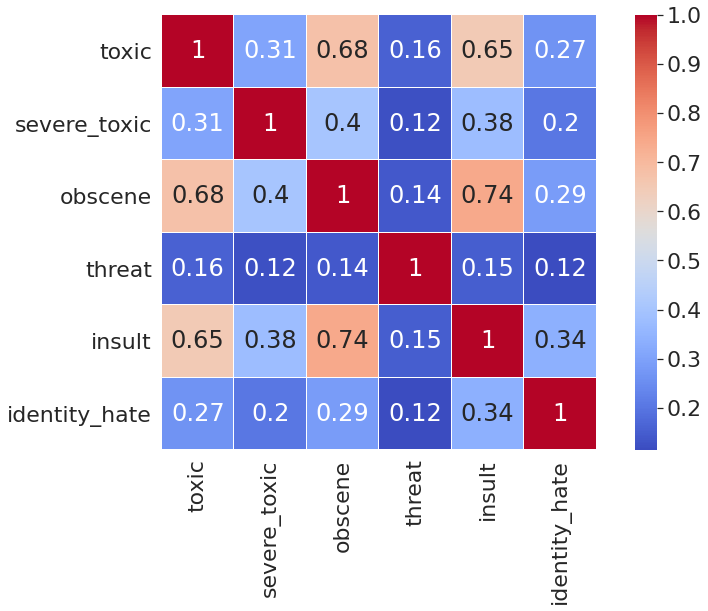

In [17]:
data = df[labels]

colormap = plt.cm.coolwarm
plt.figure(figsize = (14, 8))

sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', annot=True);

## Pré-processamento dos dados

In [0]:
import re

def clean_text(text):
    
    text = text.encode('ascii', errors = 'ignore').decode() #Decodificando caracteres em ASCII
    text = text.lower() #Apenas caracteres minúsculos
    text = re.sub(r'http\S+', ' ', text) #Evitando links
    #Evitando contrações
    text = re.sub(r'#+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    text = re.sub(r"what's", "what is ", text) 
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"won't", "will not ", text) 
    text = re.sub(r"\'ve", " have ", text) 
    text = re.sub(r"can't", "can not ", text) 
    text = re.sub(r"n't", " not ", text) 
    text = re.sub(r"isn't", "is not ", text) 
    text = re.sub(r"i'm", "i am ", text) 
    text = re.sub(r"\'re", " are ", text) 
    text = re.sub(r"\'d", " would ", text) 
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.strip(' ') #Removendo espaços do começo e fim 
    
    return text

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def remove_stopwords(text):
    
  stop_words = set(stopwords.words('english')) 

  word_tokens = word_tokenize(text) 

  filtered_sentence = [w for w in word_tokens if not w in stop_words] 

  filtered_sentence = [] 

  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
      
  return filtered_sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
tqdm.pandas(desc='Limpando o texto')
df['text_tokens'] = df['comment_text'].progress_apply(clean_text)

tqdm.pandas(desc='Removendo as stopwords e tokenizando o texto')
df['text_tokens'] = df['text_tokens'].progress_apply(remove_stopwords)

df[['comment_text', 'text_tokens']].head()

Removendo as stopwords e tokenizando o texto: 100%|██████████| 159571/159571 [01:25<00:00, 1869.39it/s]


,comment_text,text_tokens
0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,"[aww, matches, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...","[make, real, suggestions, improvement, wondere..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]"


## Separação em conjuntos de treino e teste estratificado

### Tratamento do X e do Y

In [21]:
text_tokens = []

for vet in df['text_tokens'].values:
  text_tokens.extend(vet)

# Palavras do dataset
num_words_vocab = len((list(set(text_tokens))))

print('Quantidade de palavras presentes no texto: {}'.format(len(text_tokens)))
print('Tamanho do vocabulário (palavras sem repetição): {}\n'.format(num_words_vocab))

Quantidade de palavras presentes no texto: 5464684
Tamanho do vocabulário (palavras sem repetição): 167593



In [22]:
# Transforma cada texto em uma sequência de números inteiros (cada número inteiro é o índice de um token 
  # em um dicionário). O importante é que o valor 0 que não será atribuído a nenhuma palavra.
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=num_words_vocab)
tok.fit_on_texts(df['text_tokens'].values)

df['X'] = tok.texts_to_sequences(df['text_tokens'])
 
df[['comment_text', 'text_tokens', 'X']].head()

Using TensorFlow backend.


,comment_text,text_tokens,X
0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,...","[526, 46, 48, 511, 4116, 10558, 855, 210, 1072..."
1,D'aww! He matches this background colour I'm s...,"[aww, matches, background, colour, seemingly, ...","[15539, 2354, 409, 3444, 4136, 2430, 20, 4, 79..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, trying, edit, war, guy, con...","[280, 290, 52, 138, 14, 197, 452, 2027, 352, 3..."
3,"""\nMore\nI can't make any real suggestions on ...","[make, real, suggestions, improvement, wondere...","[23, 215, 1227, 1861, 5483, 43, 2243, 374, 385..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]","[1461, 3128, 878, 432, 2]"


In [0]:
# VOCAB = {}

# for index, word in enumerate(text_tokens_set):
#   VOCAB[word] = index + 1

# VOCAB

# from tensorlayer.nlp import words_to_word_ids

# df['X'] = df['text_tokens'].apply(lambda tokens : words_to_word_ids(tokens, VOCAB))

# df[['comment_text', 'text_tokens', 'X']].head()

In [24]:
df['num_words'] = df['text_tokens'].apply(lambda x : len(x))

max_num_words = df['num_words'].max()

df[['comment_text', 'text_tokens', 'num_words']].nlargest(5, 'num_words')

,comment_text,text_tokens,num_words
32143,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,"[pig, pig, pig, pig, pig, pig, pig, pig, pig, ...",1250
61793,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOE...,"[oh, noes, oh, noes, oh, noes, oh, noes, oh, n...",1250
76598,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,"[die, fag, die, fag, die, fag, die, fag, die, ...",1250
150039,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,"[lol, lol, lol, lol, lol, lol, lol, lol, lol, ...",1250
153353,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JE...,"[fat, jew, fat, jew, fat, jew, fat, jew, fat, ...",1247


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(maxlen=max_num_words, sequences=df['X'], value=0, padding='post', truncating='post')
y = df[labels].values

print('Dimensão do X: {}'.format(X.shape))
print('Dimensão do y: {}'.format(y.shape))

Dimensão do X: (159571, 1250)
Dimensão do y: (159571, 6)


### Iterative Train-Test Split

In [0]:
from skmultilearn.model_selection import iterative_train_test_split

# 50% para cada
np.random.seed(42)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.5)

# 80% para treino e 20% para teste
np.random.seed(42)
X_train_20, y_train_20, X_test_20, y_test_20 = iterative_train_test_split(X, y, test_size=0.2)

In [27]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((79786, 1250), (79786, 6)), ((79785, 1250), (79785, 6)))

In [28]:
(X_train_20.shape, y_train_20.shape), (X_test_20.shape, y_test_20.shape)

(((127656, 1250), (127656, 6)), ((31915, 1250), (31915, 6)))

## Verificando os conjuntos de treino e teste

In [0]:
def count_occurrences_labels(df):

  CLASSES = {
    'toxic':         0,
    'severe_toxic':  0,
    'obscene':       0,
    'threat':        0,
    'insult':        0,
    'identity_hate': 0,

  }

  for vet in df.values:
    for value, label in zip(vet, CLASSES):
      CLASSES[label] += int(value)

  return CLASSES

In [0]:
def print_occurences_labels(DICT_CLASSES):

  print("Total de classificações: \n", sum(DICT_CLASSES.values()))

  print("Quantidade de ocorrências de cada classe:")
  for label in DICT_CLASSES :
    print(" " + label + ": " + str(DICT_CLASSES[label]))

In [0]:
def calculates_labels_proportion(DICT_CLASSES, labels_names):

  proportions = {}

  for label in labels_names:
    prop = DICT_CLASSES[label]/sum(DICT_CLASSES.values())
    proportions.update({label: prop})
    
  df = pd.DataFrame([proportions])

  return df

### 50% para o treino e 50% para o teste

#### Contagem de ocorrências

In [32]:
# Conjunto de dados
classif_data = count_occurrences_labels(df[labels])

print_occurences_labels(classif_data)

Total de classificações: 
 35098
Quantidade de ocorrências de cada classe:
 toxic: 15294
 severe_toxic: 1595
 obscene: 8449
 threat: 478
 insult: 7877
 identity_hate: 1405


In [33]:
# Conjunto de treino
classif_train = count_occurrences_labels(pd.DataFrame(y_train))

print_occurences_labels(classif_train)

Total de classificações: 
 17550
Quantidade de ocorrências de cada classe:
 toxic: 7647
 severe_toxic: 797
 obscene: 4225
 threat: 239
 insult: 3939
 identity_hate: 703


In [34]:
# Conjunto de teste
classif_test = count_occurrences_labels(pd.DataFrame(y_test))

print_occurences_labels(classif_test)

Total de classificações: 
 17548
Quantidade de ocorrências de cada classe:
 toxic: 7647
 severe_toxic: 798
 obscene: 4224
 threat: 239
 insult: 3938
 identity_hate: 702


In [35]:
classif_train_test = list(classif_data.values())
classif_train_test.extend(list(classif_train.values()))
classif_train_test.extend(list(classif_test.values()))

inform_train_test = pd.DataFrame(columns=['labels', 'ocorr', 'set'])

for label, value in zip((labels*3), classif_train_test):
  inform_train_test = inform_train_test.append({
      'labels': label,
      'ocorr': value
  }, ignore_index=True)

inform_train_test['set'][0:6] = 'data'
inform_train_test['set'][6:12] = 'train'
inform_train_test['set'][12:18] = 'test'

inform_train_test

,labels,ocorr,set
0,toxic,15294,data
1,severe_toxic,1595,data
2,obscene,8449,data
3,threat,478,data
4,insult,7877,data
5,identity_hate,1405,data
6,toxic,7647,train
7,severe_toxic,797,train
8,obscene,4225,train
9,threat,239,train


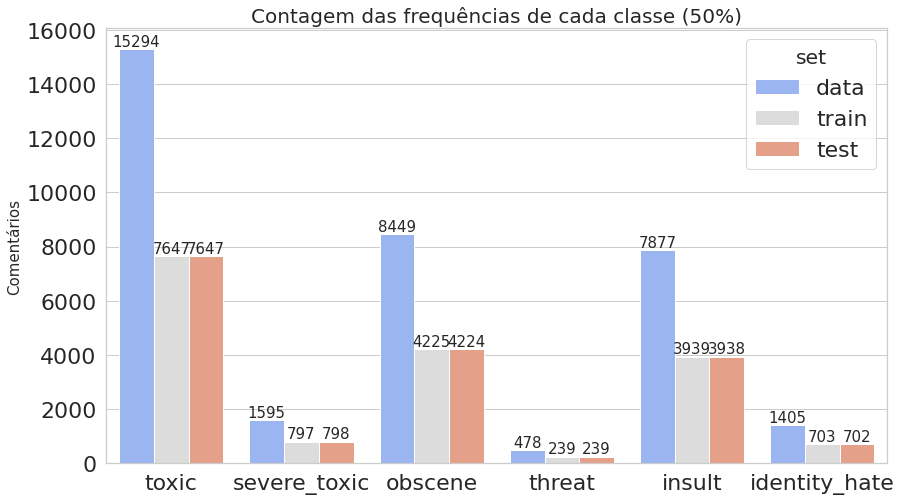

In [36]:
plot_histogram_labels('Contagem das frequências de cada classe (50%)', x_label='labels', y_label='ocorr',
                      labels=classif_train_test, hue_label='set', data=inform_train_test)

#### Proporções

In [37]:
prop_data = calculates_labels_proportion(classif_data, labels)
prop_train = calculates_labels_proportion(classif_train, labels)
prop_test = calculates_labels_proportion(classif_test, labels)

result_prop = pd.concat([prop_data, prop_train, prop_test], ignore_index=True)
result_prop.rename(index={
    0: 'dataset', 
    1: 'train_set', 
    2: 'test_set'}, inplace=True)

result_prop

,toxic,severe_toxic,obscene,threat,insult,identity_hate
dataset,0.435751,0.045444,0.240726,0.013619,0.224429,0.040031
train_set,0.435726,0.045413,0.240741,0.013618,0.224444,0.040057
test_set,0.435776,0.045475,0.240711,0.013620,0.224413,0.040005


#### Matriz de combinação

In [38]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# Order = 1
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row)
}).T.fillna(0.0)

,"(0,)","(2,)","(4,)","(1,)","(3,)","(5,)"
train,7647,4225,3939,797,239,703
test,7647,4224,3938,798,239,702


### 80% para o treino e 20% para o teste

#### Contagem de ocorrências

In [39]:
# Conjunto de treino
classif_train_20 = count_occurrences_labels(pd.DataFrame(y_train_20))

print_occurences_labels(classif_train_20)

Total de classificações: 
 28078
Quantidade de ocorrências de cada classe:
 toxic: 12235
 severe_toxic: 1276
 obscene: 6759
 threat: 382
 insult: 6302
 identity_hate: 1124


In [40]:
# Conjunto de teste
classif_test_20 = count_occurrences_labels(pd.DataFrame(y_test_20))

print_occurences_labels(classif_test_20)

Total de classificações: 
 7020
Quantidade de ocorrências de cada classe:
 toxic: 3059
 severe_toxic: 319
 obscene: 1690
 threat: 96
 insult: 1575
 identity_hate: 281


In [41]:
classif_train_test_20 = list(classif_data.values())
classif_train_test_20.extend(list(classif_train_20.values()))
classif_train_test_20.extend(list(classif_test_20.values()))

inform_train_test_20 = pd.DataFrame(columns=['labels', 'ocorr', 'set'])

for label, value in zip((labels*3), classif_train_test_20):
  inform_train_test_20 = inform_train_test_20.append({
      'labels': label,
      'ocorr': value
  }, ignore_index=True)

inform_train_test_20['set'][0:6] = 'data'
inform_train_test_20['set'][6:12] = 'train'
inform_train_test_20['set'][12:18] = 'test'

inform_train_test_20

,labels,ocorr,set
0,toxic,15294,data
1,severe_toxic,1595,data
2,obscene,8449,data
3,threat,478,data
4,insult,7877,data
5,identity_hate,1405,data
6,toxic,12235,train
7,severe_toxic,1276,train
8,obscene,6759,train
9,threat,382,train


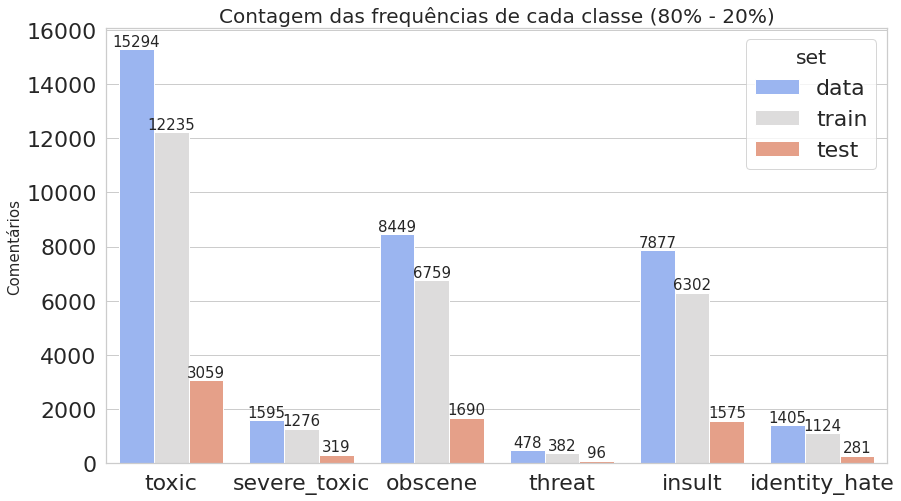

In [42]:
plot_histogram_labels('Contagem das frequências de cada classe (80% - 20%)', x_label='labels',
                      y_label='ocorr', labels=classif_train_test_20, hue_label='set',
                      data=inform_train_test_20)

#### Proporções

In [43]:
prop_data_20 = calculates_labels_proportion(classif_data, labels)
prop_train_20 = calculates_labels_proportion(classif_train_20, labels)
prop_test_20 = calculates_labels_proportion(classif_test_20, labels)

result_prop_20 = pd.concat([prop_data_20, prop_train_20, prop_test_20], ignore_index=True)
result_prop_20.rename(index={
    0: 'dataset', 
    1: 'train_set', 
    2: 'test_set'}, inplace=True)

result_prop_20

,toxic,severe_toxic,obscene,threat,insult,identity_hate
dataset,0.435751,0.045444,0.240726,0.013619,0.224429,0.040031
train_set,0.435750,0.045445,0.240722,0.013605,0.224446,0.040031
test_set,0.435755,0.045442,0.240741,0.013675,0.224359,0.040028


#### Matriz de combinação

In [44]:
# Order = 1
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train_20, order=1) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test_20, order=1) for combination in row)
}).T.fillna(0.0)

,"(2,)","(0,)","(1,)","(4,)","(5,)","(3,)"
train,6759,12235,1276,6302,1124,382
test,1690,3059,319,1575,281,96
